In [1]:
import pandas as pd 
import numpy as np 
import csv
import math 
#from fs_gcsfs import GCSFS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
import re 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt 

## Data

Datos demograficos, sociales, financieros y de negocio para la prediccion de aceptación de una tarjeta de credito

In [2]:
data = pd.read_csv("/home/jupyter/prueba_banco/data/insumo/train.csv", header =0 )

# DATA ANALYSIS

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23099 entries, 0 to 23098
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  23099 non-null  int64  
 1   Edad                23099 non-null  int64  
 2   Tipo_Trabajo        23099 non-null  object 
 3   Estado_Civil        23099 non-null  object 
 4   Educacion           23099 non-null  object 
 5   mora                23099 non-null  object 
 6   Vivienda            23099 non-null  object 
 7   Consumo             23099 non-null  object 
 8   Contacto            23099 non-null  object 
 9   Mes                 23099 non-null  object 
 10  Dia                 23099 non-null  object 
 11  Campana             23099 non-null  int64  
 12  Dias_Ultima_Camp    23099 non-null  int64  
 13  No_Contactos        23099 non-null  int64  
 14  Resultado_Anterior  23099 non-null  object 
 15  emp_var_rate        23099 non-null  float64
 16  cons

In [4]:
columns = list(data.columns)
for i in range(len(columns)):
    col1 = columns[i]
    print(col1, data[col1].isnull().sum())

ID 0
Edad 0
Tipo_Trabajo 0
Estado_Civil 0
Educacion 0
mora 0
Vivienda 0
Consumo 0
Contacto 0
Mes 0
Dia 0
Campana 0
Dias_Ultima_Camp 0
No_Contactos 0
Resultado_Anterior 0
emp_var_rate 0
cons_price_idx 0
cons_conf_idx 0
euribor3m 0
nr_employed 0
y 0


> La data no contiene valores nulos y contiene 9 variables categoricas y las restantes numericas

In [5]:
# Check balance de la data

data['y'].value_counts()

0    20509
1     2590
Name: y, dtype: int64

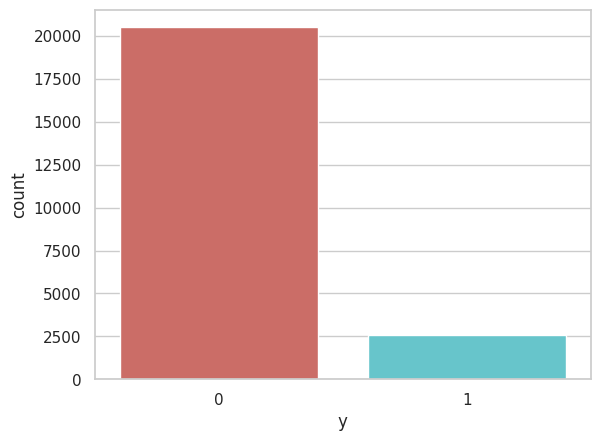

In [6]:
sns.countplot(x='y', data=data, palette='hls')
plt.show()

In [7]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of 0 is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of 1 is", pct_of_sub*100)

percentage of 0 is 88.7873933936534
percentage of 1 is 11.212606606346595


>La data no esta balanceada debido a que la relación en la variable de salida es de 89:11

In [8]:
#obtenemos solo las variables categoricas en un DF
df_categoricas = data.select_dtypes(include=[object])

In [9]:
df_categoricas

,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Mes,Dia,Resultado_Anterior
0,servicios,casado,bachillerato,unknown,no,no,telefono fijo,may,mon,sin contacto
1,servicios,casado,bachillerato,no,si,no,telefono fijo,may,mon,sin contacto
2,administrador negocio,casado,primaria,no,no,no,telefono fijo,may,mon,sin contacto
3,servicios,casado,bachillerato,no,no,si,telefono fijo,may,mon,sin contacto
4,servicios,single,bachillerato,no,si,no,telefono fijo,may,mon,sin contacto
...,...,...,...,...,...,...,...,...,...,...
23094,desempleado,soltero,preescolar,no,si,no,celular,nov,fri,satisfactorio
23095,empleado,casado,Estudiante Universitario,no,no,no,celular,nov,fri,sin contacto
23096,pensionado,casado,pregrado,no,si,no,celular,nov,fri,sin contacto
23097,tecnico,casado,Estudiante Universitario,no,no,no,celular,nov,fri,sin contacto


In [10]:
columns = list(df_categoricas.columns)
for i in range(len(columns)):
    unico= df_categoricas[columns[i]].unique()
    print(columns[i])
    print(unico)
    print(len(unico))
    print("============================")

Tipo_Trabajo
['servicios' 'administrador negocio' 'empleado' 'pensionado' 'tecnico'
 'vendedor ambulante' 'emprendedor' 'ama de casa' 'Vive de los arriendos'
 'desempleado' 'unknown' 'estudiante']
12
Estado_Civil
['casado' 'single' 'soltero' 'divorced' 'divorciado' 'unknown']
6
Educacion
['bachillerato' 'primaria' 'unknown' 'bachillerato incompleto' 'pregrado'
 'preescolar' 'Estudiante Universitario' 'Ninguno']
8
mora
['unknown' 'no' 'si']
3
Vivienda
['no' 'si' 'unknown']
3
Consumo
['no' 'si' 'unknown']
3
Contacto
['telefono fijo' 'celular']
2
Mes
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
10
Dia
['mon' 'tue' 'wed' 'thu' 'fri']
5
Resultado_Anterior
['sin contacto' 'fallido' 'satisfactorio']
3


> Al evaluar las variables categoricas se observa que existen 3 tipos de variables diferentes:
> 1. ordinal: Variables que contienen un claro orden de categoria como lo son: "Estado_Civil","Educacion", "mora","Vivienda","Consumo","Contacto","Resultado_Anterior"
> 2. nominal: Tipo_Trabajo
> 3. periodicas = dia y mes

# DATA CLEANING

> Se encuentra redundancia entre españo e ingles en la feature Estado_Civil y problemas de mayusculas en la feature eduacion. se crea la funcion clean_categorical_columns para estandarizar la data

In [11]:
def clean_categorical_columns(x):
    x = x.lower()
    if x == "divorced":
        x = "divorciado"
    elif x =="single":
        x = "soltero"
    else:
        x = x
    return x

In [12]:
columns_to_clean = ["Estado_Civil", "Educacion"]

for columns_clean in columns_to_clean :
    df_categoricas[columns_clean] = df_categoricas[columns_clean].apply(clean_categorical_columns)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
columns = list(df_categoricas.columns)
for i in range(len(columns)):
    unico= df_categoricas[columns[i]].unique()
    print(columns[i])
    print(unico)
    print(len(unico))
    print("============================")

Tipo_Trabajo
['servicios' 'administrador negocio' 'empleado' 'pensionado' 'tecnico'
 'vendedor ambulante' 'emprendedor' 'ama de casa' 'Vive de los arriendos'
 'desempleado' 'unknown' 'estudiante']
12
Estado_Civil
['casado' 'soltero' 'divorciado' 'unknown']
4
Educacion
['bachillerato' 'primaria' 'unknown' 'bachillerato incompleto' 'pregrado'
 'preescolar' 'estudiante universitario' 'ninguno']
8
mora
['unknown' 'no' 'si']
3
Vivienda
['no' 'si' 'unknown']
3
Consumo
['no' 'si' 'unknown']
3
Contacto
['telefono fijo' 'celular']
2
Mes
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
10
Dia
['mon' 'tue' 'wed' 'thu' 'fri']
5
Resultado_Anterior
['sin contacto' 'fallido' 'satisfactorio']
3


In [14]:
#Obtenemos solo las variables numericas en otro DF
df_numeric = data.select_dtypes(exclude=[object])
df_numeric

,ID,Edad,Campana,Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,57,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
1,2,37,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
2,3,40,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
3,4,56,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
4,7,25,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...
23094,32963,29,1,9,1,-1.1,94767.0,-50.8,1028.0,4963.6,0
23095,32964,46,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23096,32965,56,2,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23097,32966,44,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,1


# DATA PREPROCESSING 

### Variables periodicas 

> Al ser vairables periodicas podemos representar cada una de ellas en un espacio de senos y cosenos.

In [15]:
def numeric_months(month):
    
    if month == "ene":
        month = 1
    elif month == "feb":
        month = 2
    elif month == "mar":
        month = 3
    elif month == "apr":
        month = 4
    elif month == "may":
        month = 5
    elif month == "jun":
        month = 6
    elif month == "jul":
        month = 7
    elif month == "ago":
        month = 8
    elif month == "sep":
        month = 9
    elif month == "oct":
        month = 10
    elif month == "nov":
        month = 11
    else:
        month = 5
    return month

def numeric_days(day):
    
    if day == "mon":
        day = 1
    elif day == "tue":
        day = 2
    elif day == "wed":
        day = 3
    elif day == "thu":
        day = 4
    elif day == "fri":
        day = 5
    elif day == "sat":
        day = 6
    else:
        day = 7
    return day

def days_to_cosenos(df_categoricas, column):
    df_categoricas["num_"+column]= df_categoricas[column].apply(lambda x: numeric_days(str(x))) #Convierto dias a numeros
    df_categoricas["norm_" + column] = 2 * math.pi * df_categoricas["num_"+column] / df_categoricas["num_"+column].max() #Normalizamos los valores de las columnas en un cilo de 0-2pi

    df_categoricas["cos_"+ column] = np.cos(df_categoricas["norm_" + column]) #Calculo el coseno para los valores normalizados 
    df_categoricas["sin_"+ column] = np.sin(df_categoricas["norm_" + column]) #Calculo el seno para los valores normalizados 
    
    return df_categoricas 


def months_to_cosenos(df_categoricas, column):
    df_categoricas["num_"+column]= df_categoricas[column].apply(lambda x: numeric_months(str(x))) #Convierto meses a numeros
    df_categoricas["norm_" + column] = 2 * math.pi * df_categoricas["num_"+column] / df_categoricas["num_"+column].max() #Normalizamos los valores de las columnas en un cilo de 0-2pi

    df_categoricas["cos_"+ column] = np.cos(df_categoricas["norm_" + column]) #Calculo el coseno para los valores normalizados 
    df_categoricas["sin_"+ column] = np.sin(df_categoricas["norm_" + column]) #Calculo el seno para los valores normalizados 
    
    return df_categoricas 

In [16]:
df_categoricas = days_to_cosenos(df_categoricas, "Dia")
columns_delete1 = ["norm_Dia", "Dia","num_Dia"] #columnas a eliminar debido a que fueron creadas temporalmente
df_categoricas = df_categoricas.drop(columns_delete1,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [17]:
df_categoricas = months_to_cosenos(df_categoricas, "Mes")
columns_delete2 = ["norm_Mes", "Mes","num_Mes"] #columnas a eliminar debido a que fueron creadas temporalmente
df_categoricas = df_categoricas.drop(columns_delete2,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_categoricas

,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,sin_Mes
0,servicios,casado,bachillerato,unknown,no,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
1,servicios,casado,bachillerato,no,si,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
2,administrador negocio,casado,primaria,no,no,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
3,servicios,casado,bachillerato,no,no,si,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
4,servicios,soltero,bachillerato,no,si,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
23094,desempleado,soltero,preescolar,no,si,no,celular,satisfactorio,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23095,empleado,casado,estudiante universitario,no,no,no,celular,sin contacto,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23096,pensionado,casado,pregrado,no,si,no,celular,sin contacto,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23097,tecnico,casado,estudiante universitario,no,no,no,celular,sin contacto,1.000000,-2.449294e-16,1.000000,-1.133108e-15


### Categorical variables (ONE HOT ENCODING)

> Se aplica one hot enconding a las variables que no tienen una categoria clara o estandar

In [19]:
encoder_columns =["Tipo_Trabajo"]

suma = 0
for i in range(len(encoder_columns)):
    suma = suma + len(df_categoricas[encoder_columns[i]].unique())
    print(encoder_columns[i], len(df_categoricas[encoder_columns[i]].unique()))
print("el numero de columnas nuevas es: ", suma)

Tipo_Trabajo 12
el numero de columnas nuevas es:  12


In [20]:
#obtenemos un dataframe con las variables a las que se le aplica One Hot Encoding
data_OH = df_categoricas.filter(encoder_columns)
data_OH.head()

,Tipo_Trabajo
0,servicios
1,servicios
2,administrador negocio
3,servicios
4,servicios


In [21]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
OH_cols = pd.DataFrame(OH_encoder.fit_transform(data_OH)) #aplicamos OH encoder a la columna
OH_cols.index = data_OH.index
OH_cols

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23094,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23095,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Categorical variables (LABEL ENCODING)

In [22]:

columns_LE = ["Estado_Civil","Educacion", "mora","Vivienda","Consumo","Contacto","Resultado_Anterior"]

# instancia de labelencoder
labelencoder = LabelEncoder()
for i in range(len(columns_LE)):    
    # Asignación de numerical values
    df_categoricas[columns_LE[i]] = labelencoder.fit_transform(df_categoricas[columns_LE[i]])
                                                                          
                                                                          
df_categoricas

,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,sin_Mes
0,servicios,0,0,2,0,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
1,servicios,0,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
2,administrador negocio,0,6,0,0,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
3,servicios,0,0,0,0,1,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
4,servicios,2,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
23094,desempleado,2,4,0,1,0,0,1,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23095,empleado,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23096,pensionado,0,5,0,1,0,0,2,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23097,tecnico,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,-1.133108e-15


In [23]:
final_categoricas = df_categoricas.drop("Tipo_Trabajo",1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [24]:
#unimos cada uno de los dataframes que fueron trabajados como variables categoricas
final_categoricas = pd.concat([final_categoricas, OH_cols], axis=1)
final_categoricas.head()

,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,...,2,3,4,5,6,7,8,9,10,11
0,0,0,2,0,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,0,1,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,6,0,0,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,0,0,1,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
final_categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23099 entries, 0 to 23098
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estado_Civil        23099 non-null  int64  
 1   Educacion           23099 non-null  int64  
 2   mora                23099 non-null  int64  
 3   Vivienda            23099 non-null  int64  
 4   Consumo             23099 non-null  int64  
 5   Contacto            23099 non-null  int64  
 6   Resultado_Anterior  23099 non-null  int64  
 7   cos_Dia             23099 non-null  float64
 8   sin_Dia             23099 non-null  float64
 9   cos_Mes             23099 non-null  float64
 10  sin_Mes             23099 non-null  float64
 11  0                   23099 non-null  float64
 12  1                   23099 non-null  float64
 13  2                   23099 non-null  float64
 14  3                   23099 non-null  float64
 15  4                   23099 non-null  float64
 16  5   

In [26]:
#obtenemos el DF final el cual es el concat entre el df categorical y el numerico
final_df = pd.concat([final_categoricas, df_numeric], axis=1)
final_df

,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,...,Edad,Campana,Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,2,0,0,1,2,0.309017,9.510565e-01,-0.959493,...,57,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
1,0,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,...,37,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
2,0,6,0,0,0,1,2,0.309017,9.510565e-01,-0.959493,...,40,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
3,0,0,0,0,1,1,2,0.309017,9.510565e-01,-0.959493,...,56,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
4,2,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,...,25,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23094,2,4,0,1,0,0,1,1.000000,-2.449294e-16,1.000000,...,29,1,9,1,-1.1,94767.0,-50.8,1028.0,4963.6,0
23095,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,...,46,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23096,0,5,0,1,0,0,2,1.000000,-2.449294e-16,1.000000,...,56,2,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23097,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,...,44,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,1


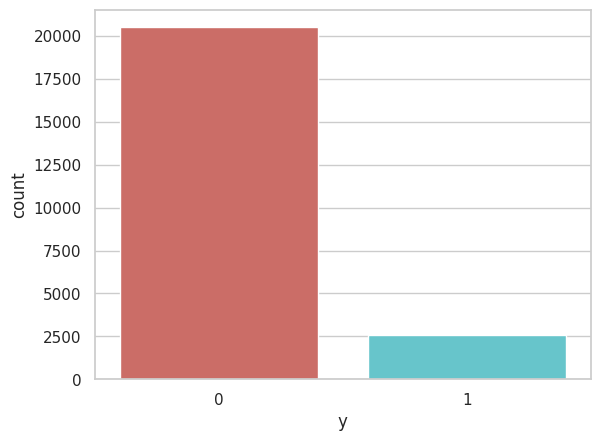

In [27]:
sns.countplot(x='y', data=final_df, palette='hls')
plt.show()

#### Balance Data

In [28]:
X = final_df.loc[:, final_df.columns != 'y']
y = final_df.loc[:, final_df.columns == 'y']

> Para solucionar el caso de los datos de salida no balanceados se hara uso de SMOTE Algorithm que basicamente opera de la siguiente manera:

>1. Crea muestras sinteticas de las clases secundaria en lugar de crear copias.
>2. Escoje uno de los k-nearest-neighbors y lo usa para crear un valor random modificado similar a una observación

In [29]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length  oversampled  ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of 1",len(os_data_y[os_data_y['y']==1]))
print("Proportion of 0 ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of 1 ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length  oversampled   28728
Number of 0 in oversampled data 14364
Number of 1 14364
Proportion of 0  0.5
Proportion of 1  0.5


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


> Se observa que la data ahora se encuentra balanceada

## ENTREMANIEMTO PRIMER MODELO

Para el primer modelo se entrenara un LOGISTIC REGRESSION MODE. Para el entrenamiento de este modelo, previamente se realizara un analisis de las features con ayuda de la libreria sklearn para identificar las features que no representan un mayor peso al momento de predecir el valor "y"

#### Recursive Feature Elimination

In [30]:
data_final_vars=final_df.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [31]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, step = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

for feature in rfe.support_.nonzero():
    print(os_data_X.columns[feature])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Num Features: 16
Selected Features: [ True  True  True  True  True False False  True  True  True False False
 False False False False False False False False False False False  True
  True  True  True False False  True  True  True  True]
Feature Ranking: [1 1 1 1 1 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 1 1 1 1]
Index(['Estado_Civil', 'Educacion', 'mora', 'Vivienda', 'Consumo', 'cos_Dia',
       'sin_Dia', 'cos_Mes', 'ID', 'Edad', 'Campana', 'Dias_Ultima_Camp',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')


In [32]:
os_data_X

,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,...,ID,Edad,Campana,Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,2,0,0,1,0,0,2,-0.809017,-5.877853e-01,-0.959493,...,27378,33,3,999,0,-1.8,92893.0,-46.2,1281.000000,5099.1
1,1,0,0,1,1,1,2,1.000000,-2.449294e-16,-0.959493,...,9420,44,4,999,0,1.4,94465.0,-41.8,4959.000000,5228.1
2,0,0,0,1,0,0,2,0.309017,-9.510565e-01,-0.654861,...,10911,54,1,999,0,1.4,93918.0,-42.7,4963.000000,5228.1
3,0,6,0,0,0,1,2,1.000000,-2.449294e-16,-0.959493,...,6091,30,2,999,0,1.1,93994.0,-36.4,4864.000000,5191.0
4,2,5,0,1,0,0,2,0.309017,-9.510565e-01,-0.142315,...,31463,38,1,999,0,-1.8,93369.0,-34.8,0.643000,5008.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28723,0,0,0,1,0,0,2,-0.809017,-5.877853e-01,1.000000,...,20499,35,1,999,0,-0.1,93.2,-42.0,4.120000,5195.8
28724,0,4,1,1,0,0,2,0.309017,-9.510565e-01,-0.654861,...,13677,56,7,999,0,1.4,93918.0,-42.7,4962.000000,5228.1
28725,0,0,0,0,1,0,1,0.309017,-9.510565e-01,-0.959493,...,27580,43,1,999,0,-1.8,92893.0,-46.2,1266.000000,5099.1
28726,0,0,0,1,0,0,2,-0.809017,5.877853e-01,-0.654861,...,10339,29,1,999,0,1.4,93918.0,-42.7,4962.000000,5228.1


In [33]:
cols=['Estado_Civil', 'Educacion', 'mora', 'Vivienda', 'Consumo', 'cos_Dia',
       'sin_Dia', 'cos_Mes', 'ID', 'Edad', 'Campana', 'Dias_Ultima_Camp',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
X=os_data_X[cols]
y=os_data_y['y']

#### Implementacion del modelo

In [34]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.516903
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.254     
Dependent Variable: y                AIC:              29731.1613
Date:               2023-01-06 23:16 BIC:              29863.4113
No. Observations:   28728            Log-Likelihood:   -14850.   
Df Model:           15               LL-Null:          -19913.   
Df Residuals:       28712            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Estado_Civil     -0.3173   0.0187 -16.9506 0.0000 -0.3540 -0.2806
Educacion        -0.0426   0.0067  -6.3592 0.0000 -0.0558 -0.0295


> los p-values para cada una de las features seleccionadas es bajo, al igual que el Std. Error por consiguiente se mantiene la selección de features

In [45]:
dataset = final_df.values
X1 = dataset[:, :-1]
y1 = dataset[:,-1]

In [47]:
len(X1)

23099

## LOGISTIC REGRESSION MODEL FITTING

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [49]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [25]:
#Dividimos nuestra data en los vectores de Features and target
dataset = final_df.values
X = dataset[:, :-1]
y = dataset[:,-1]

#Realizamos split a nuestro set de datos, 75 train y 25 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17324, 33) (5775, 33) (17324,) (5775,)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[5050   69]
 [ 532  124]]
